In [677]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [678]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [679]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394967 entries, 0 to 2394966
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.5 MB


# reduce to 1 million events

In [680]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [681]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,25034,0.14,25.034
1,23992,0.15,23.992
2,23729,0.15,23.729
3,23884,0.15,23.884
4,24127,0.15,24.127
...,...,...,...
999995,27261,0.13,27.261
999996,27290,0.13,27.290
999997,26670,0.13,26.670
999998,26329,0.14,26.329


### conversion Interval -> kWh

In [682]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,25034,0.14,25.034,143.804426
1,23992,0.15,23.992,150.050017
2,23729,0.15,23.729,151.713094
3,23884,0.15,23.884,150.728521
4,24127,0.15,24.127,149.210428
...,...,...,...,...
999995,27261,0.13,27.261,132.056784
999996,27290,0.13,27.290,131.916453
999997,26670,0.13,26.670,134.983127
999998,26329,0.14,26.329,136.731361


### Cumul Total interval

In [683]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [684]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

27108186783000

### Calcul de la date de base = now - cumul_interval

In [685]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 9, 4, 18, 18, 43, 212595)

In [686]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [687]:
conso_data.iloc[0]


Interval     25034.000000
kWh              0.140000
sec             25.034000
Wh             143.804426
cumul(ms)    25034.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [688]:
base

datetime.datetime(2024, 9, 4, 18, 18, 43, 212595)

## créer les dates

In [689]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-09-04 18:19:08.246595
1        2024-09-04 18:19:32.238595
2        2024-09-04 18:19:55.967595
3        2024-09-04 18:20:19.851595
4        2024-09-04 18:20:43.978595
                    ...            
999995   2025-07-15 12:20:03.860595
999996   2025-07-15 12:20:31.150595
999997   2025-07-15 12:20:57.820595
999998   2025-07-15 12:21:24.149595
999999   2025-07-15 12:21:49.995595
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [690]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,25034,0.14,25.034,143.804426,25034,2024-09-04 18:19:08.246595,04/09/24
1,23992,0.15,23.992,150.050017,49026,2024-09-04 18:19:32.238595,04/09/24
2,23729,0.15,23.729,151.713094,72755,2024-09-04 18:19:55.967595,04/09/24
3,23884,0.15,23.884,150.728521,96639,2024-09-04 18:20:19.851595,04/09/24
4,24127,0.15,24.127,149.210428,120766,2024-09-04 18:20:43.978595,04/09/24
...,...,...,...,...,...,...,...
999995,27261,0.13,27.261,132.056784,27108080648,2025-07-15 12:20:03.860595,15/07/25
999996,27290,0.13,27.290,131.916453,27108107938,2025-07-15 12:20:31.150595,15/07/25
999997,26670,0.13,26.670,134.983127,27108134608,2025-07-15 12:20:57.820595,15/07/25
999998,26329,0.14,26.329,136.731361,27108160937,2025-07-15 12:21:24.149595,15/07/25


### save conso_data with dates

In [691]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [692]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('15/07/25', 15, 7, 2025, '12:22:05')

In [693]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [694]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 997974 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2026 non-null   int64         
 1   kWh        2026 non-null   float64       
 2   sec        2026 non-null   float64       
 3   Wh         2026 non-null   float64       
 4   cumul(ms)  2026 non-null   int64         
 5   dates      2026 non-null   datetime64[ns]
 6   days       2026 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 126.6+ KB


In [695]:
end = time.time()
print(end - start)

32.46768856048584


### grouped by days

In [696]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [697]:
data = list(df_grp['kWh'])
print(data)

[0.855, 3.527, 3.66, 3.604, 3.155, 2.616, 1.799, 1.792, 1.795, 1.794, 2.413, 1.925, 1.787, 1.793, 1.788, 1.819, 1.82, 1.818, 1.815, 1.817, 1.817, 1.815, 1.819, 1.784, 1.787, 1.784, 1.785, 1.783, 1.798, 1.788, 1.791, 1.785, 1.792, 1.801, 1.798, 1.799, 1.801, 1.786, 1.787, 1.787, 1.789, 1.797, 1.791, 1.799, 1.804, 1.793, 1.802, 1.798, 2.643, 3.999, 3.68, 3.896, 3.092, 3.353, 4.136, 3.355, 3.509, 3.988, 3.324, 3.732, 3.575, 3.975, 3.204, 3.316, 3.394, 4.094, 3.284, 3.392, 3.817, 3.228, 3.541, 3.293, 3.915, 3.352, 3.42, 3.753, 4.41, 3.604, 3.855, 3.37, 4.224, 3.498, 3.446, 3.284, 3.861, 3.687, 4.116, 3.212, 3.729, 3.808, 3.155, 3.685, 3.653, 3.386, 3.881, 3.19, 4.064, 3.449, 3.704, 4.072, 3.41, 4.532, 3.264, 3.463, 3.111, 3.22, 3.429, 3.351, 3.421, 3.427, 4.603, 4.547, 3.227, 3.453, 3.636, 3.931, 3.545, 4.459, 4.18, 4.086, 3.776, 3.734, 3.553, 3.537, 4.387, 3.164, 3.382, 3.399, 3.449, 3.611, 3.378, 4.555, 3.26, 3.786, 3.249, 3.603, 3.544, 3.287, 3.993, 3.279, 4.681, 3.932, 3.312, 4.432, 3.

In [698]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [699]:
end = time.time()
print(end - start)

34.21925973892212


### plot function by day
#### show('dd/mm/yy')

In [700]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


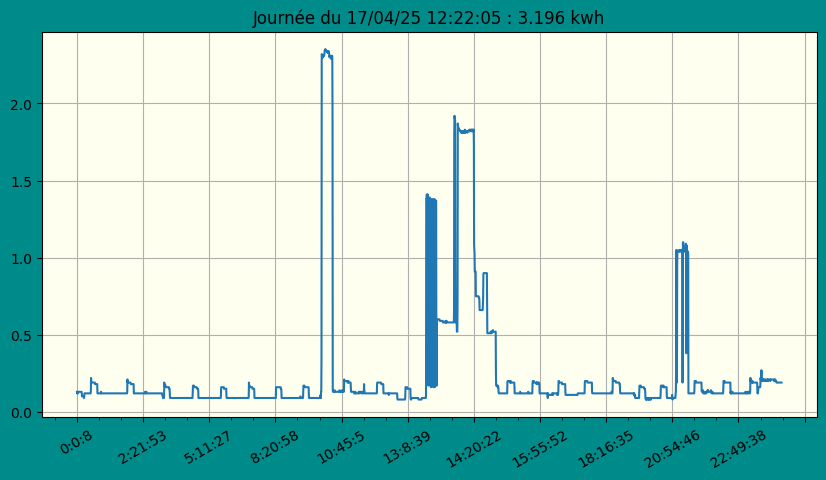

In [701]:
show('17/04/25')

In [702]:
end = time.time()
print(end - start)

36.7322301864624


### 1 kWh window in data of one day
#### df = conso_day

In [703]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997974,35960,0.10,35.960,100.111235,27063696279,2025-07-15 00:00:19.491595,15/07/25
997975,36024,0.10,36.024,99.933378,27063732303,2025-07-15 00:00:55.515595,15/07/25
997976,34392,0.10,34.392,104.675506,27063766695,2025-07-15 00:01:29.907595,15/07/25
997977,33713,0.11,33.713,106.783733,27063800408,2025-07-15 00:02:03.620595,15/07/25
997978,34673,0.10,34.673,103.827185,27063835081,2025-07-15 00:02:38.293595,15/07/25
...,...,...,...,...,...,...,...
999995,27261,0.13,27.261,132.056784,27108080648,2025-07-15 12:20:03.860595,15/07/25
999996,27290,0.13,27.290,131.916453,27108107938,2025-07-15 12:20:31.150595,15/07/25
999997,26670,0.13,26.670,134.983127,27108134608,2025-07-15 12:20:57.820595,15/07/25
999998,26329,0.14,26.329,136.731361,27108160937,2025-07-15 12:21:24.149595,15/07/25


In [704]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [705]:
df = conso_day
len(df)

2026

In [706]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-15 00:00:19.491595	2025-07-15 08:20:23.348595	8h 20m 3s 	1000
2025-07-15 08:20:23.348595	2025-07-15 12:10:14.704595	3h 49m 51s 	2000


In [707]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301335
dtype: float64

In [708]:
end = time.time()
print(end - start)

37.03550338745117


## mean for data grouped by days

In [709]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.174603
dtype: float64

In [710]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(2.026)

# conso by date


In [711]:
# select day
day = today

#day = '16/08/24'
day

'15/07/25'

In [712]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997974,35960,0.10,35.960,100.111235,27063696279,2025-07-15 00:00:19.491595,15/07/25
997975,36024,0.10,36.024,99.933378,27063732303,2025-07-15 00:00:55.515595,15/07/25
997976,34392,0.10,34.392,104.675506,27063766695,2025-07-15 00:01:29.907595,15/07/25
997977,33713,0.11,33.713,106.783733,27063800408,2025-07-15 00:02:03.620595,15/07/25
997978,34673,0.10,34.673,103.827185,27063835081,2025-07-15 00:02:38.293595,15/07/25
...,...,...,...,...,...,...,...
999995,27261,0.13,27.261,132.056784,27108080648,2025-07-15 12:20:03.860595,15/07/25
999996,27290,0.13,27.290,131.916453,27108107938,2025-07-15 12:20:31.150595,15/07/25
999997,26670,0.13,26.670,134.983127,27108134608,2025-07-15 12:20:57.820595,15/07/25
999998,26329,0.14,26.329,136.731361,27108160937,2025-07-15 12:21:24.149595,15/07/25


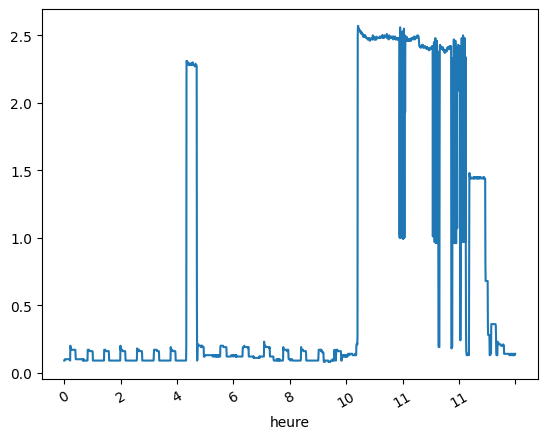

In [713]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [714]:
end = time.time()
print(end - start)

37.78267192840576


### grouped by 'heure'

In [715]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 997974 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2026 non-null   int64         
 1   kWh        2026 non-null   float64       
 2   sec        2026 non-null   float64       
 3   Wh         2026 non-null   float64       
 4   cumul(ms)  2026 non-null   int64         
 5   dates      2026 non-null   datetime64[ns]
 6   days       2026 non-null   object        
 7   heure      2026 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 142.5+ KB


In [716]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997974,35960,0.10,35.960,100.111235,27063696279,2025-07-15 00:00:19.491595,15/07/25
997975,36024,0.10,36.024,99.933378,27063732303,2025-07-15 00:00:55.515595,15/07/25
997976,34392,0.10,34.392,104.675506,27063766695,2025-07-15 00:01:29.907595,15/07/25
997977,33713,0.11,33.713,106.783733,27063800408,2025-07-15 00:02:03.620595,15/07/25
997978,34673,0.10,34.673,103.827185,27063835081,2025-07-15 00:02:38.293595,15/07/25
...,...,...,...,...,...,...,...
999995,27261,0.13,27.261,132.056784,27108080648,2025-07-15 12:20:03.860595,15/07/25
999996,27290,0.13,27.290,131.916453,27108107938,2025-07-15 12:20:31.150595,15/07/25
999997,26670,0.13,26.670,134.983127,27108134608,2025-07-15 12:20:57.820595,15/07/25
999998,26329,0.14,26.329,136.731361,27108160937,2025-07-15 12:21:24.149595,15/07/25


In [717]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [718]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     109
1     109
2     103
3     101
4     109
5     167
6     143
7     125
8     104
9     111
10    111
11    684
12     50
Name: kWh, dtype: int64

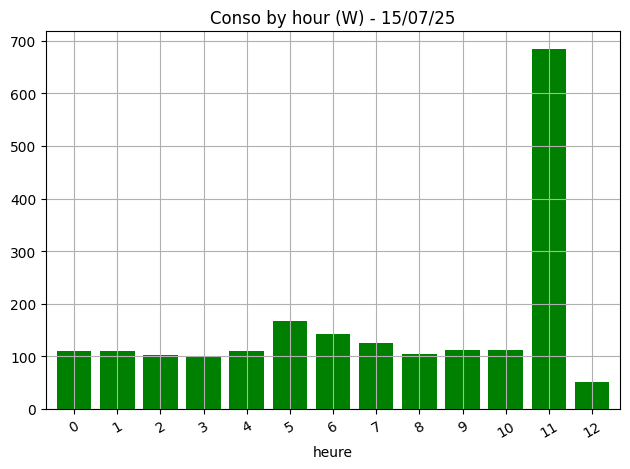

In [719]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [720]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 04/09/24 to 15/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     315 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [721]:
# give the periods of 1 kwh in a day
period()

2025-07-15 00:00:19.491595	2025-07-15 08:20:23.348595	8h 20m 3s 	1000


In [722]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [723]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [724]:
df_grp.mean()


kWh    3.174603
dtype: float64

In [725]:
df_grp.head()


,kWh
days,
04/09/24,0.855
05/09/24,3.527
06/09/24,3.660
07/09/24,3.604
08/09/24,3.155


In [726]:
df_grp.tail()


,kWh
days,
11/07/25,2.678
12/07/25,2.601
13/07/25,2.712
14/07/25,3.273
15/07/25,2.026


In [727]:
end = time.time()
print(end - start)

38.87919473648071


# plot les 100 derniers jours


In [728]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    2.99689
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

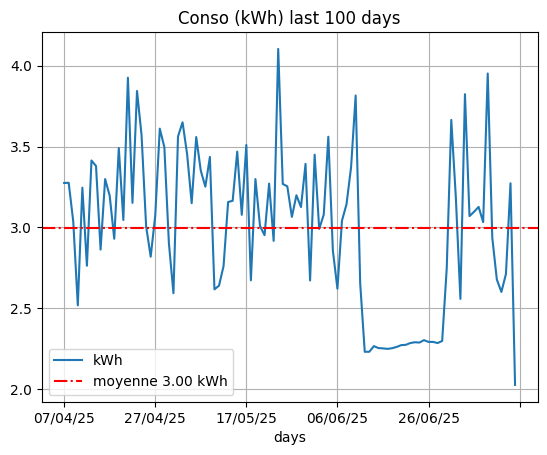

In [729]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [730]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.026
max,4.104


In [731]:
end = time.time()
print(end - start)

39.68050146102905


In [732]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('15/06/25', '10/07/25')

In [733]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.6869
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

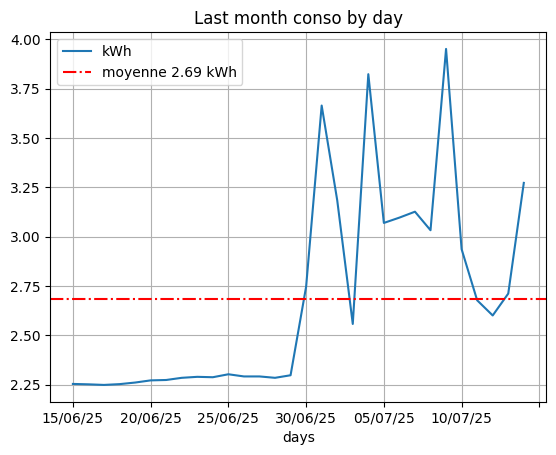

In [734]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [735]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 09/07/25 3.952
Min : 17/06/25 2.249


# Temps de conso par tranche de 1 kWh

In [736]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


3
2025-07-15 00:00:19.491595	2025-07-15 08:20:23.348595	8h 20m 3s 	1000
2025-07-15 08:20:23.348595	2025-07-15 12:10:14.704595	3h 49m 51s 	2000
2025-07-15 12:10:14.704595	2025-07-15 12:21:49.995595	0h 11m 35s 	26


In [737]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('12:22:05', 2.026, 2026)

In [738]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 997974 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2026 non-null   int64         
 1   kWh        2026 non-null   float64       
 2   sec        2026 non-null   float64       
 3   Wh         2026 non-null   float64       
 4   cumul(ms)  2026 non-null   int64         
 5   dates      2026 non-null   datetime64[ns]
 6   days       2026 non-null   object        
 7   heure      2026 non-null   object        
 8   hours      2026 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 158.3+ KB


In [739]:
conso_hours['heure'], conso_hours['hours']

(997974     0
 997975     0
 997976     0
 997977     0
 997978     0
           ..
 999995    12
 999996    12
 999997    12
 999998    12
 999999    12
 Name: heure, Length: 2026, dtype: object,
 997974    00
 997975    00
 997976    00
 997977    00
 997978    00
           ..
 999995    12
 999996    12
 999997    12
 999998    12
 999999    12
 Name: hours, Length: 2026, dtype: object)

In [740]:
end = time.time()
print(end - start)

40.449766874313354


# select number of days to display


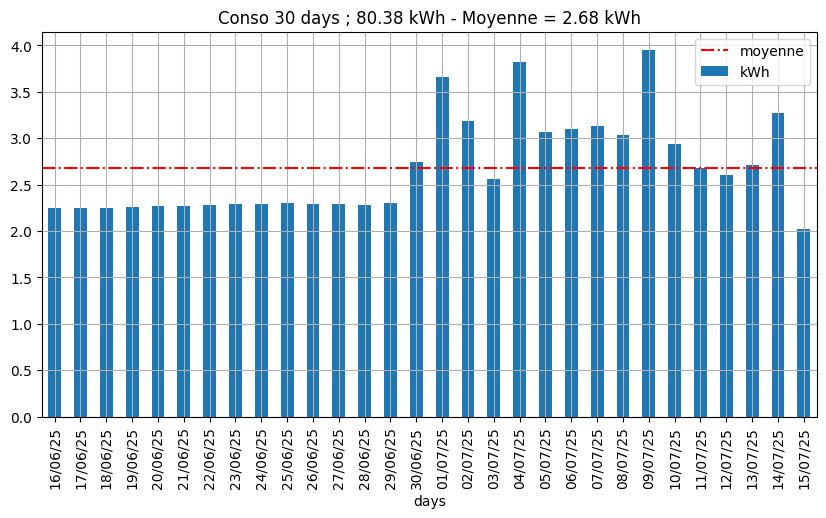

In [741]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


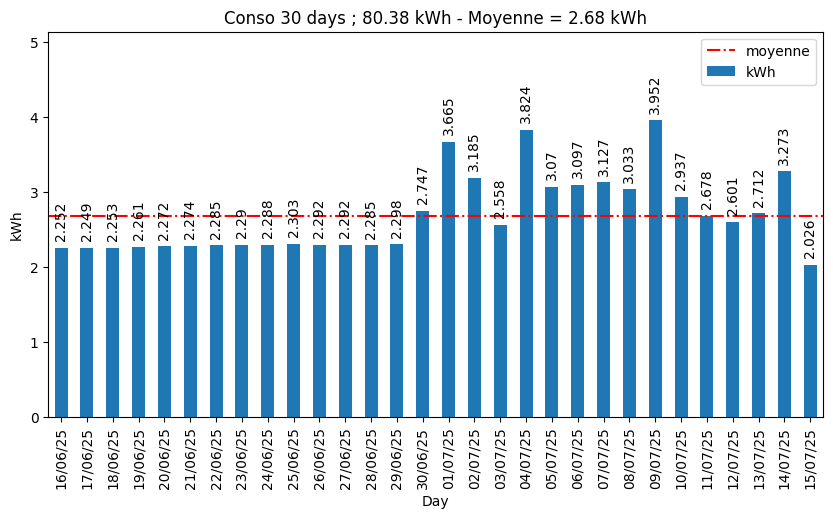

In [742]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [743]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
16/06/25    2.252
17/06/25    2.249
18/06/25    2.253
19/06/25    2.261
20/06/25    2.272
21/06/25    2.274
22/06/25    2.285
23/06/25    2.290
24/06/25    2.288
25/06/25    2.303
26/06/25    2.292
27/06/25    2.292
28/06/25    2.285
29/06/25    2.298
30/06/25    2.747
01/07/25    3.665
02/07/25    3.185
03/07/25    2.558
04/07/25    3.824
05/07/25    3.070
06/07/25    3.097
07/07/25    3.127
08/07/25    3.033
09/07/25    3.952
10/07/25    2.937
11/07/25    2.678
12/07/25    2.601
13/07/25    2.712
14/07/25    3.273
15/07/25    2.026
Name: kWh, dtype: float64

In [744]:
x_labels=df_grp.tail(span).index
x_labels

Index(['16/06/25', '17/06/25', '18/06/25', '19/06/25', '20/06/25', '21/06/25',
       '22/06/25', '23/06/25', '24/06/25', '25/06/25', '26/06/25', '27/06/25',
       '28/06/25', '29/06/25', '30/06/25', '01/07/25', '02/07/25', '03/07/25',
       '04/07/25', '05/07/25', '06/07/25', '07/07/25', '08/07/25', '09/07/25',
       '10/07/25', '11/07/25', '12/07/25', '13/07/25', '14/07/25', '15/07/25'],
      dtype='object', name='days')

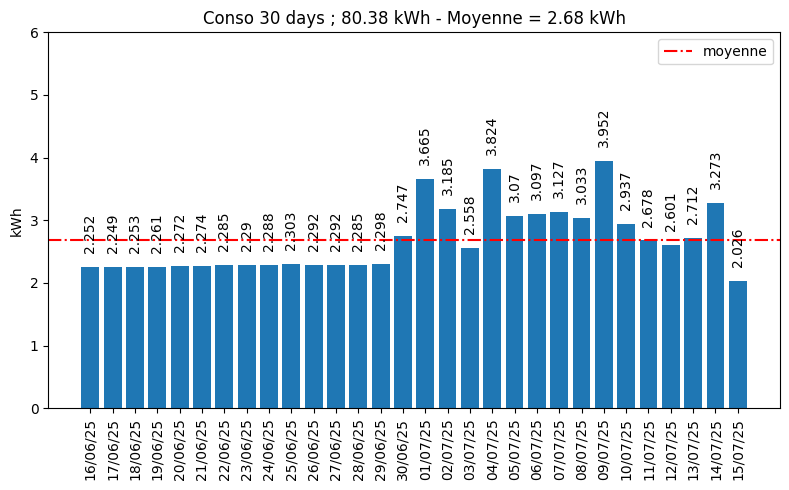

In [745]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [746]:
end = time.time()
print(end - start)

47.299970865249634


In [747]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

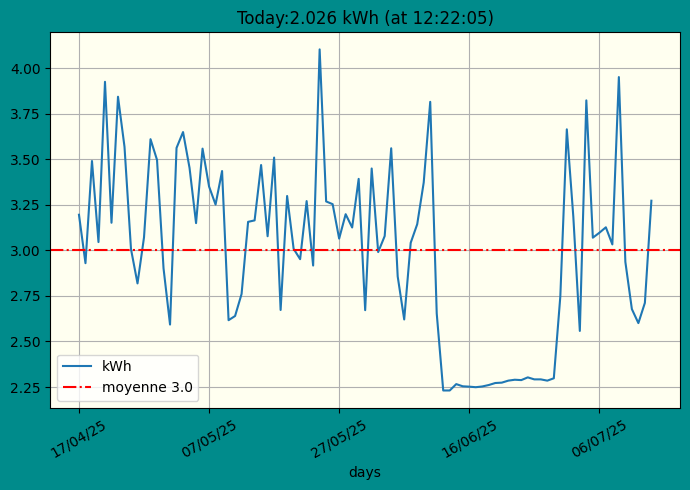

In [748]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

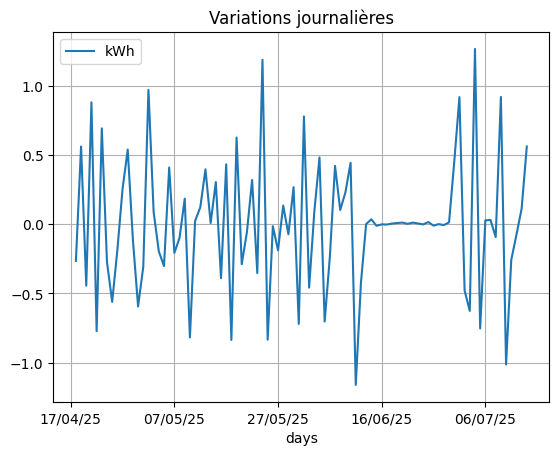

In [749]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [750]:
end = time.time()
print(end - start)

48.494014263153076


# Data from 21/08/23

In [751]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,25034,0.14,25.034,143.804426,25034,2024-09-04 18:19:08.246595,04/09/24,18,2024-09,04
1,23992,0.15,23.992,150.050017,49026,2024-09-04 18:19:32.238595,04/09/24,18,2024-09,04
2,23729,0.15,23.729,151.713094,72755,2024-09-04 18:19:55.967595,04/09/24,18,2024-09,04
3,23884,0.15,23.884,150.728521,96639,2024-09-04 18:20:19.851595,04/09/24,18,2024-09,04
4,24127,0.15,24.127,149.210428,120766,2024-09-04 18:20:43.978595,04/09/24,18,2024-09,04
...,...,...,...,...,...,...,...,...,...,...
999995,27261,0.13,27.261,132.056784,27108080648,2025-07-15 12:20:03.860595,15/07/25,12,2025-07,15
999996,27290,0.13,27.290,131.916453,27108107938,2025-07-15 12:20:31.150595,15/07/25,12,2025-07,15
999997,26670,0.13,26.670,134.983127,27108134608,2025-07-15 12:20:57.820595,15/07/25,12,2025-07,15
999998,26329,0.14,26.329,136.731361,27108160937,2025-07-15 12:21:24.149595,15/07/25,12,2025-07,15


In [752]:
end = time.time()
print(end - start)

92.91825413703918


In [753]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

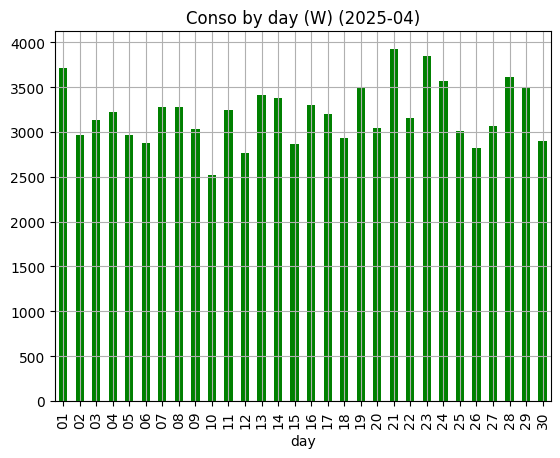

In [754]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [755]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3200.2)

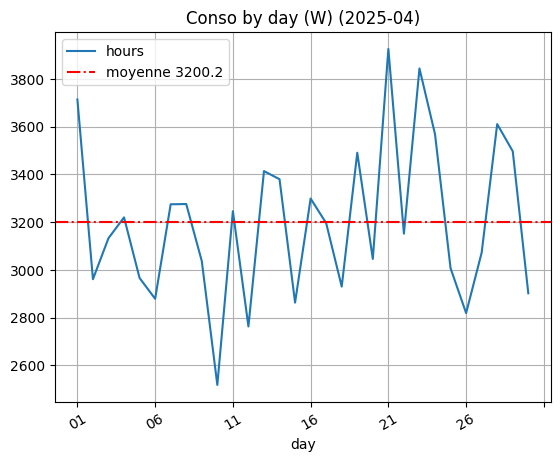

In [756]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [757]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

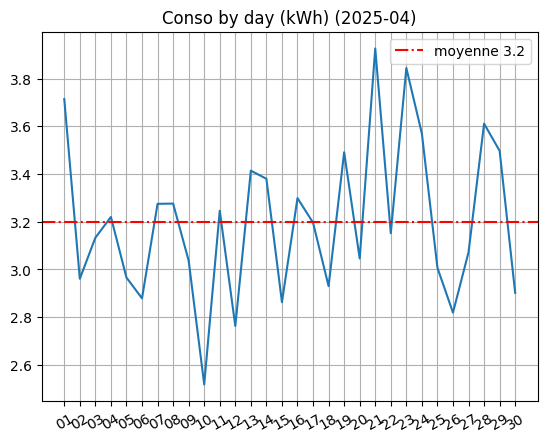

In [758]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [759]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [760]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [761]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-09,55983,55983,55983
2024-10,73320,73320,73320
2024-11,108176,108176,108176
2024-12,113985,113985,113985
2025-01,113874,113874,113874
2025-02,104279,104279,104279
2025-03,111821,111821,111821
2025-04,96006,96006,96006
2025-05,98607,98607,98607


In [762]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [763]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [764]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
04/09/24,855
05/09/24,3527
06/09/24,3660
07/09/24,3604
08/09/24,3155
...,...
11/07/25,2678
12/07/25,2601
13/07/25,2712


In [765]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,25034,0.14,25.034,143.804426,25034,2024-09-04 18:19:08.246595,04/09/24,18,2024-09,04
1,23992,0.15,23.992,150.050017,49026,2024-09-04 18:19:32.238595,04/09/24,18,2024-09,04
2,23729,0.15,23.729,151.713094,72755,2024-09-04 18:19:55.967595,04/09/24,18,2024-09,04
3,23884,0.15,23.884,150.728521,96639,2024-09-04 18:20:19.851595,04/09/24,18,2024-09,04
4,24127,0.15,24.127,149.210428,120766,2024-09-04 18:20:43.978595,04/09/24,18,2024-09,04
...,...,...,...,...,...,...,...,...,...,...
999995,27261,0.13,27.261,132.056784,27108080648,2025-07-15 12:20:03.860595,15/07/25,12,2025-07,15
999996,27290,0.13,27.290,131.916453,27108107938,2025-07-15 12:20:31.150595,15/07/25,12,2025-07,15
999997,26670,0.13,26.670,134.983127,27108134608,2025-07-15 12:20:57.820595,15/07/25,12,2025-07,15
999998,26329,0.14,26.329,136.731361,27108160937,2025-07-15 12:21:24.149595,15/07/25,12,2025-07,15


In [766]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
04/09/24 18    0       04/09/24    18  0.14
               1       04/09/24    18  0.15
               2       04/09/24    18  0.15
               3       04/09/24    18  0.15
               4       04/09/24    18  0.15
...                         ...   ...   ...
15/07/25 12    999995  15/07/25    12  0.13
               999996  15/07/25    12  0.13
               999997  15/07/25    12  0.13
               999998  15/07/25    12  0.14
               999999  15/07/25    12  0.14

[1000000 rows x 3 columns]

In [767]:
groupallbyday.indices.keys()

dict_keys(['04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/11/24', '17/11/24', '18/11/24', '19/11/24', '20/11/24', '21/11/24', '22/11/24', '23/11/24', '24/11/24', '25/1

In [768]:
groupallbydayhours.indices.keys()

dict_keys([('04/09/24', '18'), ('04/09/24', '19'), ('04/09/24', '20'), ('04/09/24', '21'), ('04/09/24', '22'), ('04/09/24', '23'), ('05/09/24', '18'), ('05/09/24', '19'), ('05/09/24', '20'), ('05/09/24', '21'), ('05/09/24', '22'), ('05/09/24', '23'), ('05/09/24', '00'), ('05/09/24', '01'), ('05/09/24', '02'), ('05/09/24', '03'), ('05/09/24', '04'), ('05/09/24', '05'), ('05/09/24', '06'), ('05/09/24', '07'), ('05/09/24', '08'), ('05/09/24', '09'), ('05/09/24', '10'), ('05/09/24', '11'), ('05/09/24', '12'), ('05/09/24', '13'), ('05/09/24', '14'), ('05/09/24', '15'), ('05/09/24', '16'), ('05/09/24', '17'), ('06/09/24', '18'), ('06/09/24', '19'), ('06/09/24', '20'), ('06/09/24', '21'), ('06/09/24', '22'), ('06/09/24', '23'), ('06/09/24', '00'), ('06/09/24', '01'), ('06/09/24', '02'), ('06/09/24', '03'), ('06/09/24', '04'), ('06/09/24', '05'), ('06/09/24', '06'), ('06/09/24', '07'), ('06/09/24', '08'), ('06/09/24', '09'), ('06/09/24', '10'), ('06/09/24', '11'), ('06/09/24', '12'), ('06/09/2

In [769]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
04/09/24,855,855
05/09/24,3527,3527
06/09/24,3660,3660
07/09/24,3604,3604
08/09/24,3155,3155
...,...,...
11/07/25,2678,2678
12/07/25,2601,2601
13/07/25,2712,2712


In [770]:
grp_by_day['kWh'].cumsum()

days
04/09/24        855
05/09/24       4382
06/09/24       8042
07/09/24      11646
08/09/24      14801
             ...   
11/07/25     989388
12/07/25     991989
13/07/25     994701
14/07/25     997974
15/07/25    1000000
Name: kWh, Length: 315, dtype: int64

In [771]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
04/09/24 18     111
         19     163
         20     128
         21     151
         22     149
...             ...
15/07/25 08     104
         09     111
         10     111
         11     684
         12      50

[7531 rows x 1 columns]

In [772]:
grp_by_dayhours['kWh'].cumsum()

days      hours
04/09/24  18           111
          19           274
          20           402
          21           553
          22           702
                    ...   
15/07/25  08        999044
          09        999155
          10        999266
          11        999950
          12       1000000
Name: kWh, Length: 7531, dtype: int64

In [773]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
04/09/24 18     111     111    NaN
         19     163     274   52.0
         20     128     402  -35.0
         21     151     553   23.0
         22     149     702   -2.0
...             ...     ...    ...
15/07/25 08     104    1070  -21.0
         09     111    1181    7.0
         10     111    1292    0.0
         11     684    1976  573.0
         12      50    2026 -634.0

[7531 rows x 3 columns]

In [774]:
today, grp_by_dayhours.loc[today]

('15/07/25',
        kWh  cumsum   diff
 hours                    
 00     109     109    NaN
 01     109     218    0.0
 02     103     321   -6.0
 03     101     422   -2.0
 04     109     531    8.0
 05     167     698   58.0
 06     143     841  -24.0
 07     125     966  -18.0
 08     104    1070  -21.0
 09     111    1181    7.0
 10     111    1292    0.0
 11     684    1976  573.0
 12      50    2026 -634.0)

Text(0.5, 1.0, 'Cumul journalier')

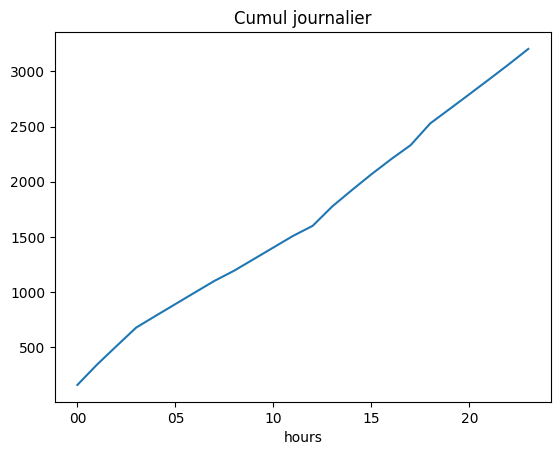

In [775]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

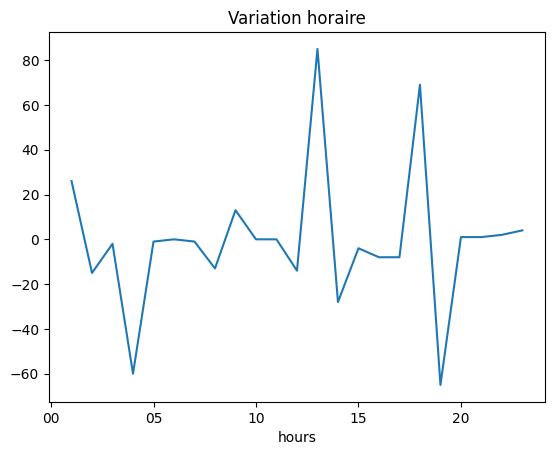

In [776]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [777]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

315

In [778]:
df_grp.tail(n)['kWh'].describe()


count    315.000000
mean       3.174603
std        0.743589
min        0.855000
25%        2.791000
50%        3.312000
75%        3.656500
max        4.787000
Name: kWh, dtype: float64

In [779]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [780]:
n, np.nanmean(df_grp.tail(n))

(315, np.float64(3.1746031746031744))

Text(0.5, 1.0, '315 days')

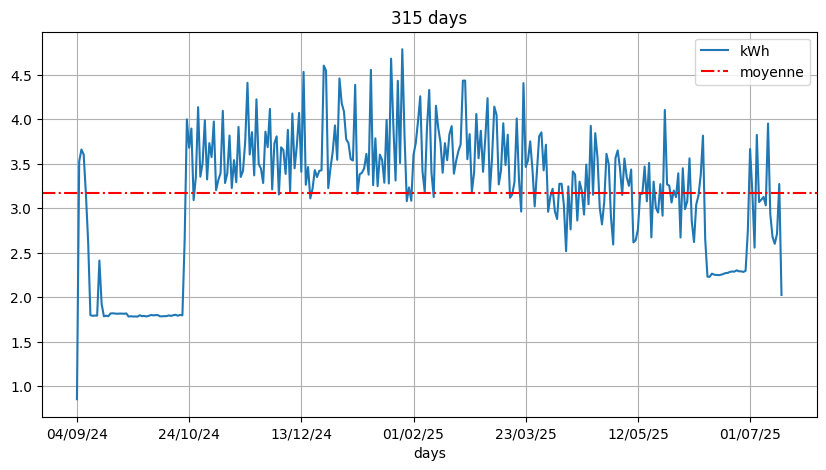

In [781]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

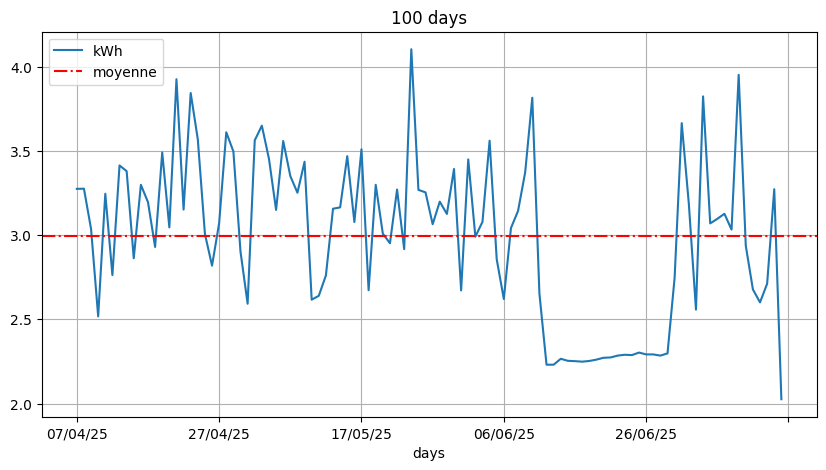

In [782]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [783]:
np.nanmean(df_grp.tail(span))

np.float64(2.99689)

In [784]:
df_grp['kWh']

days
04/09/24    0.855
05/09/24    3.527
06/09/24    3.660
07/09/24    3.604
08/09/24    3.155
            ...  
11/07/25    2.678
12/07/25    2.601
13/07/25    2.712
14/07/25    3.273
15/07/25    2.026
Name: kWh, Length: 315, dtype: float64

In [785]:
df_grp.describe()

,kWh
count,315.000000
mean,3.174603
std,0.743589
min,0.855000
25%,2.791000
50%,3.312000
75%,3.656500
max,4.787000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

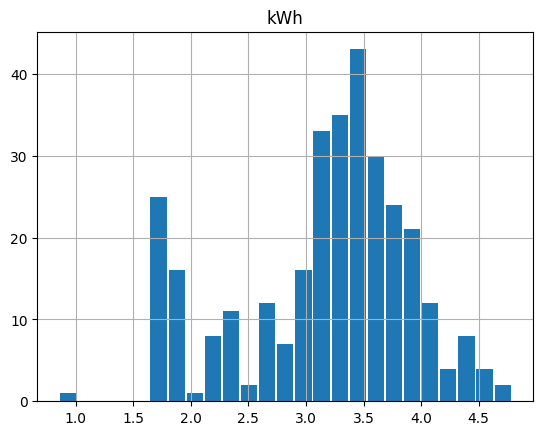

In [786]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [787]:
df_grp.tail(span)['kWh']

days
07/04/25    3.275
08/04/25    3.276
09/04/25    3.037
10/04/25    2.518
11/04/25    3.246
            ...  
11/07/25    2.678
12/07/25    2.601
13/07/25    2.712
14/07/25    3.273
15/07/25    2.026
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [788]:
day

'15/07/25'

In [789]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,109,109,NaN
01,109,218,0.0
02,103,321,-6.0
03,101,422,-2.0
04,109,531,8.0
05,167,698,58.0
06,143,841,-24.0
07,125,966,-18.0
08,104,1070,-21.0


In [790]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


13

In [791]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 14)

In [792]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [793]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])

In [794]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
Name: days, dtype: float64

In [795]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [796]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 00 to 12
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     13 non-null     int64  
 1   cumsum  13 non-null     int64  
 2   diff    12 non-null     float64
 3   days    13 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 520.0+ bytes


In [797]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
Name: days, dtype: float64

In [798]:
day

'15/07/25'

In [799]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,109,109,NaN,1.0
01,109,218,0.0,2.0
02,103,321,-6.0,3.0
03,101,422,-2.0,4.0
04,109,531,8.0,5.0
05,167,698,58.0,6.0
06,143,841,-24.0,7.0
07,125,966,-18.0,8.0
08,104,1070,-21.0,9.0


In [800]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_3340\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(2.026)

In [801]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
04/09/24 18     111     111    NaN   NaN
         19     163     274   52.0   NaN
         20     128     402  -35.0   NaN
         21     151     553   23.0   NaN
         22     149     702   -2.0   NaN
...             ...     ...    ...   ...
15/07/25 08     104    1070  -21.0   9.0
         09     111    1181    7.0  10.0
         10     111    1292    0.0  11.0
         11     684    1976  573.0  12.0
         12      50    2026 -634.0  13.0

[7531 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '15/07/25: kWh    2.026\ndtype: float64')

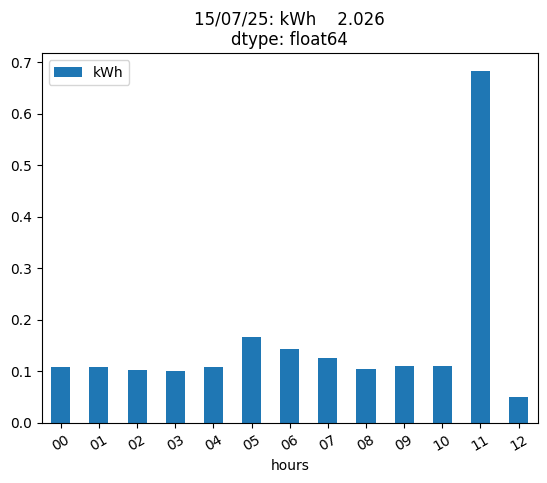

In [802]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [803]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'],
      dtype='object', name='hours')

# Conso du jour


In [804]:
grp_by_dayhours.count()

kWh       7531
cumsum    7531
diff      7216
days        13
dtype: int64

'27/01/25'

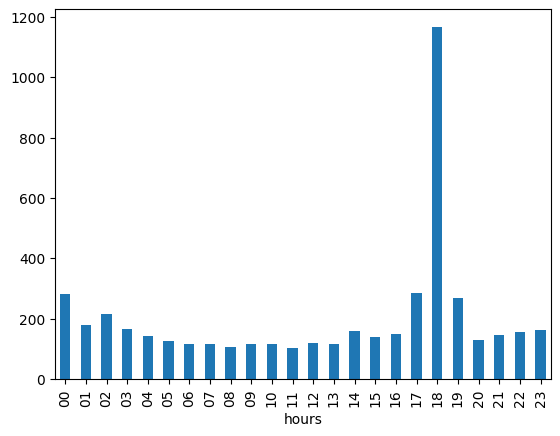

In [805]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [806]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 299.689 , Moyenne= 2.99689


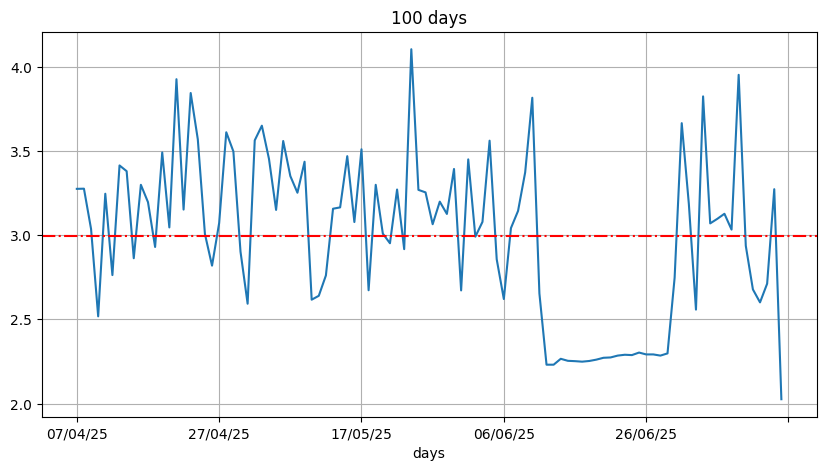

In [807]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [808]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 12:23:26, Minutes in day: 743


In [809]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [810]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:52.75


In [811]:
end - start

112.75125169754028

In [812]:
#df = conso_day
show_tranches()

3
2025-07-15 00:00:19.491595	2025-07-15 08:20:23.348595	8h 20m 3s 	1000
2025-07-15 08:20:23.348595	2025-07-15 12:10:14.704595	3h 49m 51s 	2000
2025-07-15 12:10:14.704595	2025-07-15 12:21:49.995595	0h 11m 35s 	26


In [813]:
df_grp.tail(7)['kWh']

days
09/07/25    3.952
10/07/25    2.937
11/07/25    2.678
12/07/25    2.601
13/07/25    2.712
14/07/25    3.273
15/07/25    2.026
Name: kWh, dtype: float64

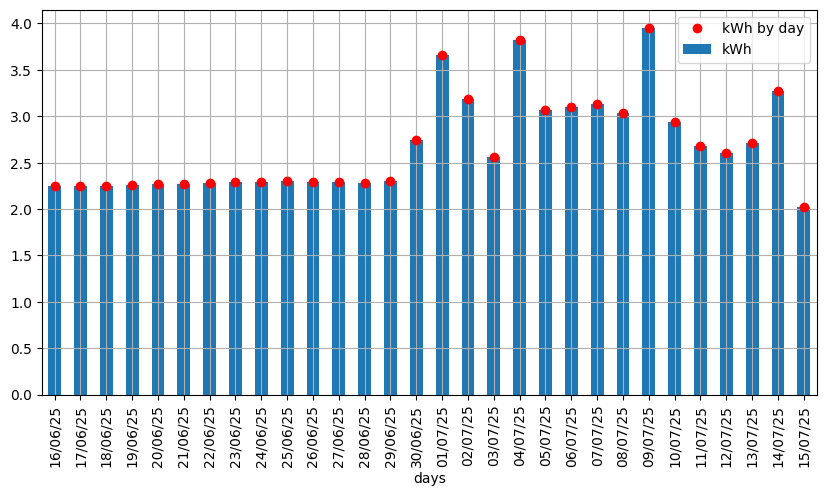

In [814]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), kind='bar', layout='tight', grid=True)
plt.plot(df_grp.tail(30)['kWh'], 'ro', label='kWh by day')
plt.legend()

# Today

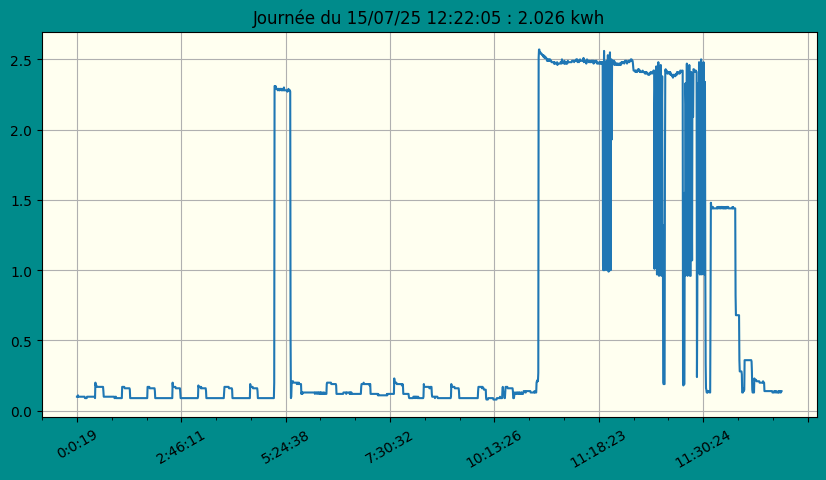

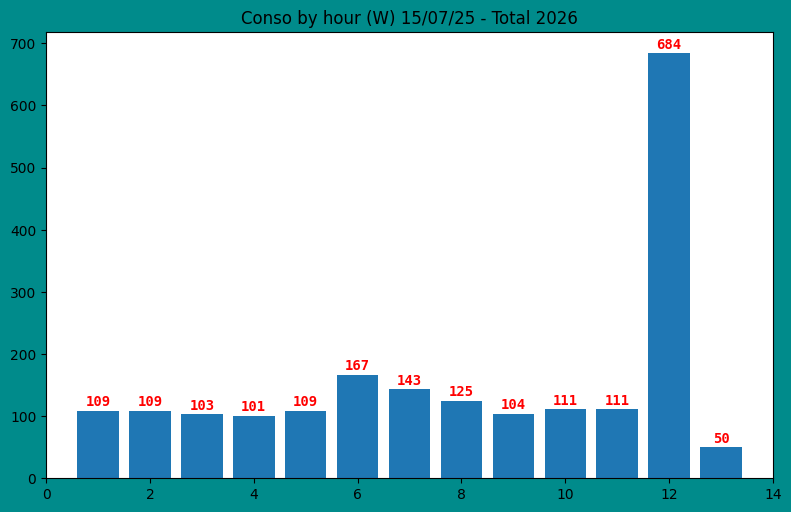

In [815]:
show(today,bgcolor='ivory')
conso_by_hour(today)

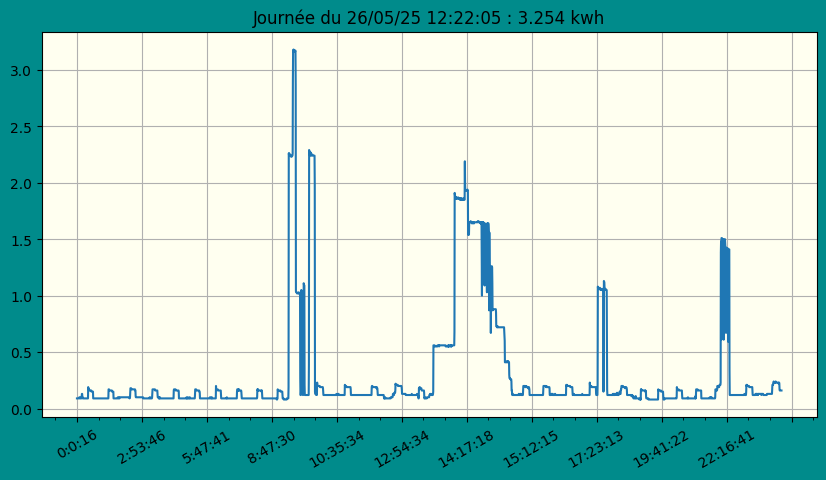

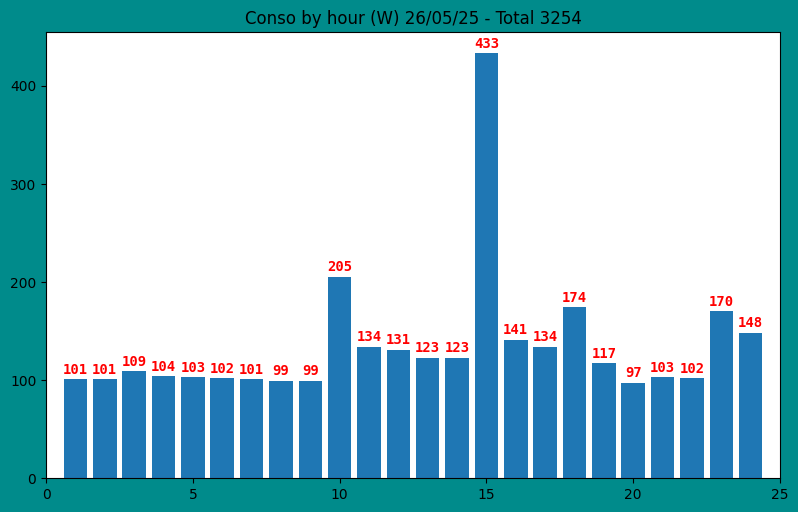

In [816]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

27/01/25


(None, 4787)

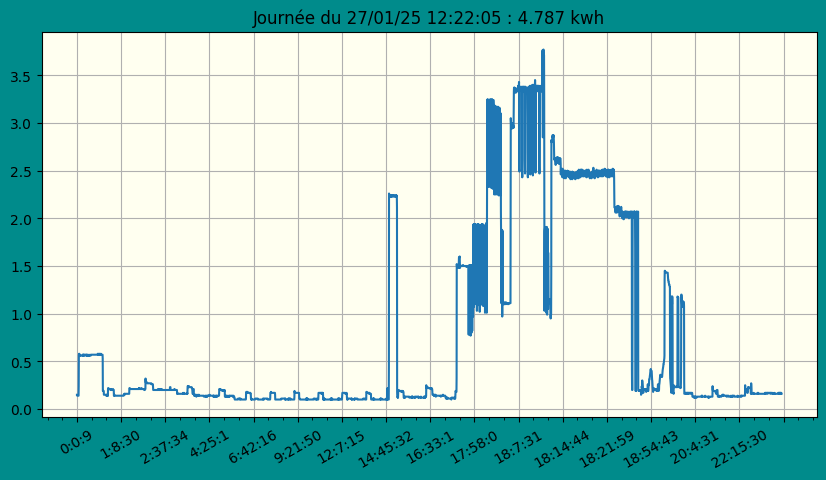

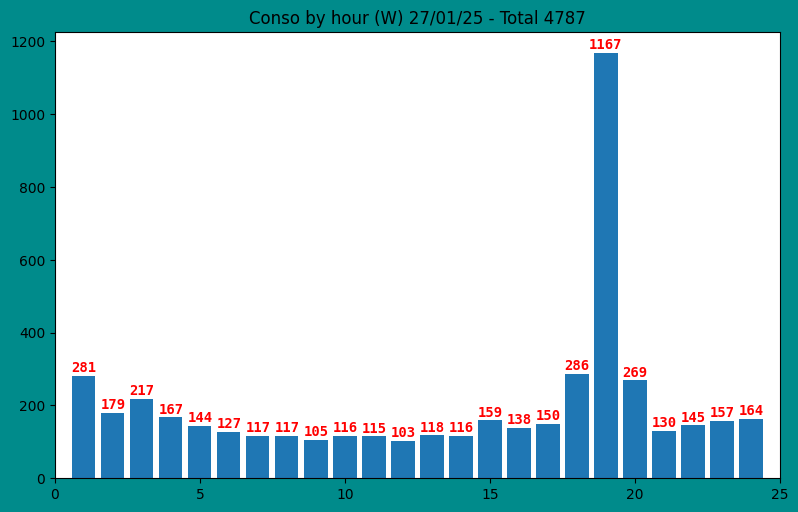

In [817]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

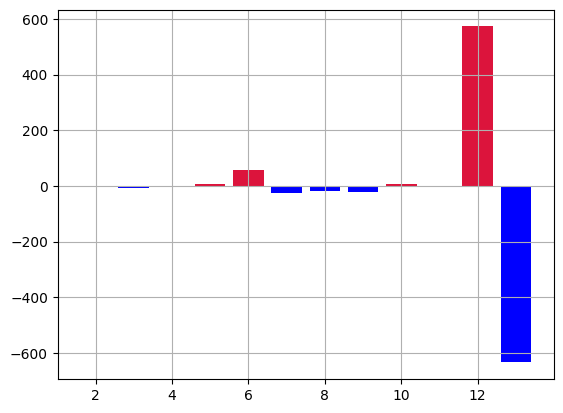

In [818]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

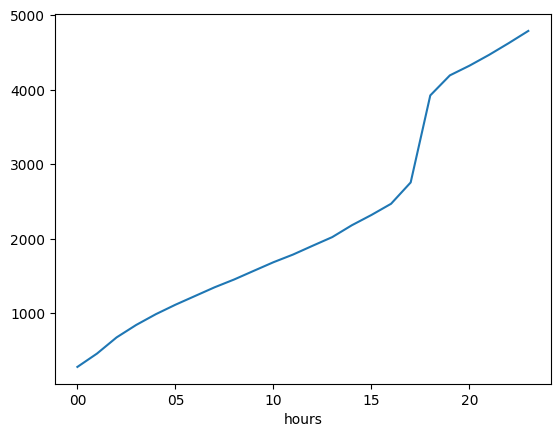

In [819]:
data.cumsum().plot()


<Axes: xlabel='hours'>

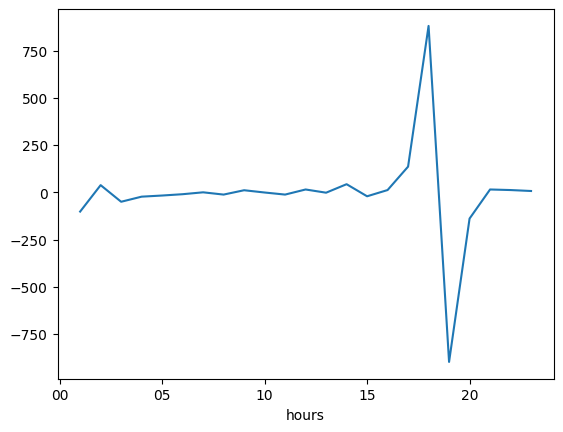

In [820]:
# evolution par heure
data.diff().plot()

In [821]:
data.diff().describe()

count     23.000000
mean      -5.086957
std      272.908895
min     -898.000000
25%      -19.000000
50%       -1.000000
75%       13.500000
max      881.000000
Name: kWh, dtype: float64

<Axes: >

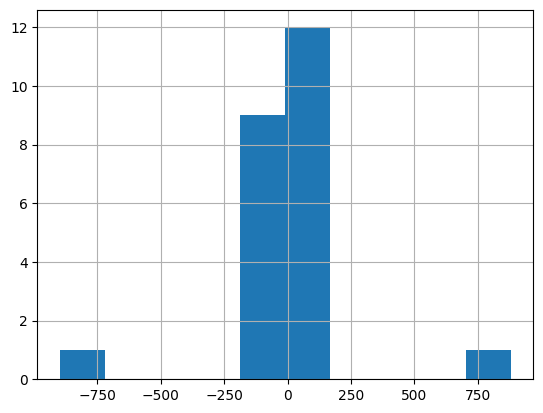

In [822]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [823]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp'

# list store files csv


In [824]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('27/01/25', None)

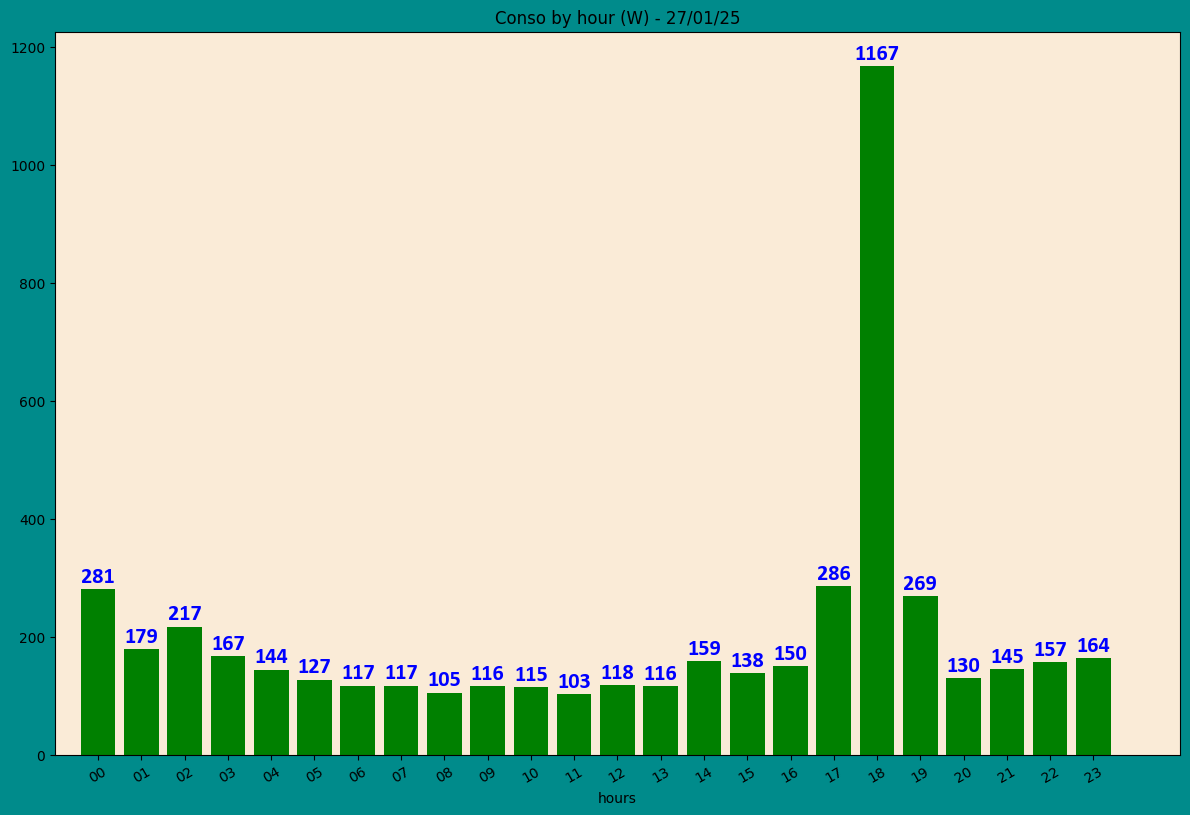

In [825]:
day,conso_byhour(day)

In [826]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


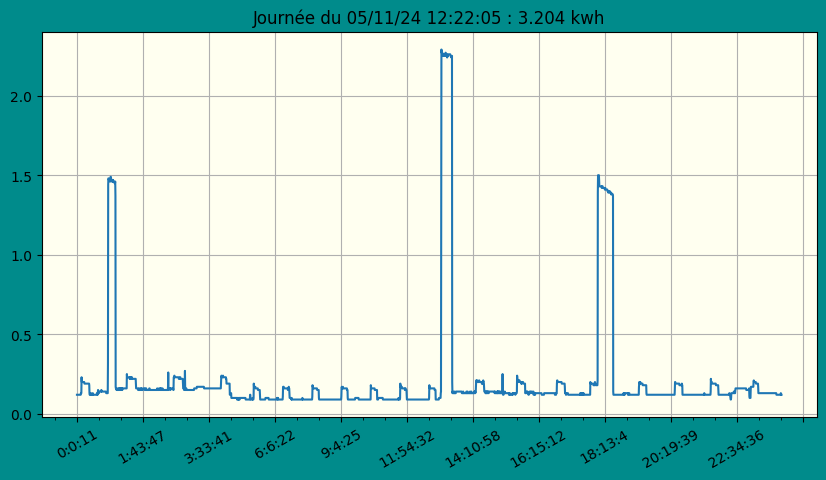

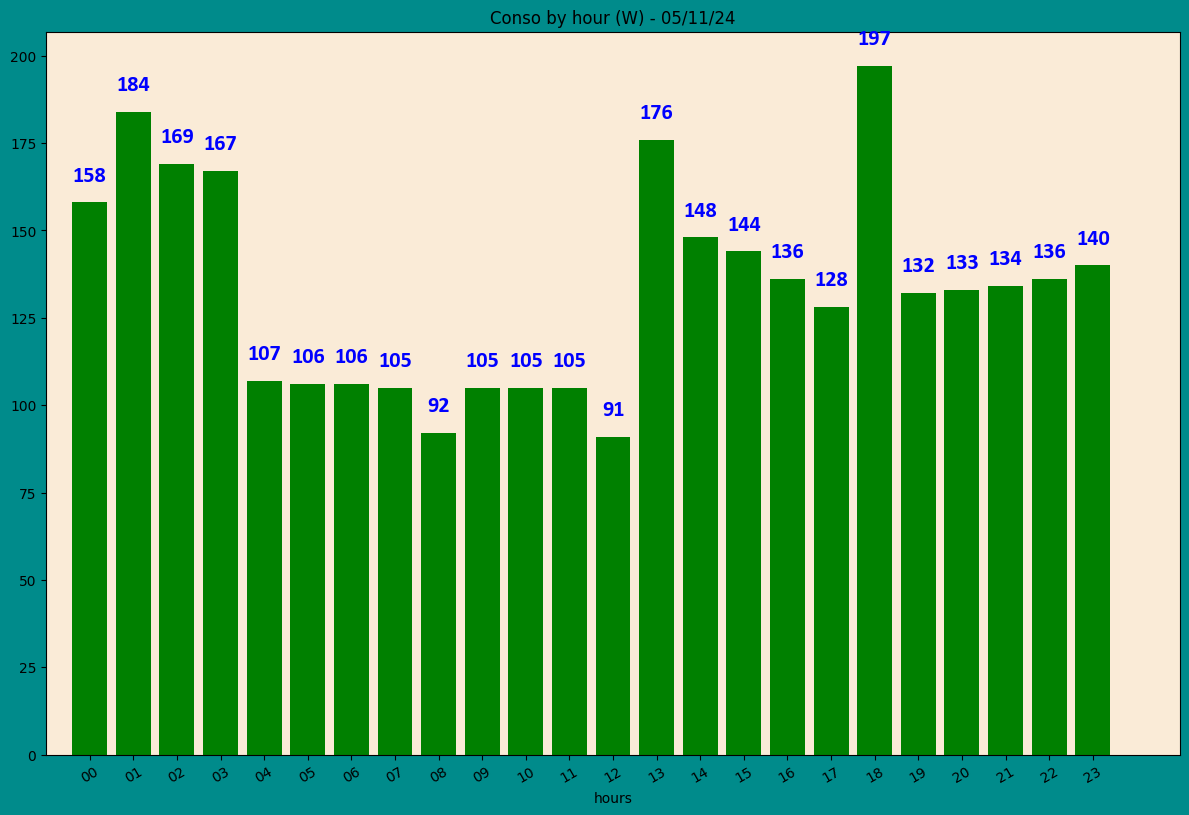

In [827]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [828]:
month

,day,hours,months,kWh
681438,01,00,2025-04,0.21
681439,01,00,2025-04,0.21
681440,01,00,2025-04,0.21
681441,01,00,2025-04,0.21
681442,01,00,2025-04,0.21
...,...,...,...,...
777439,30,23,2025-04,0.09
777440,30,23,2025-04,0.09
777441,30,23,2025-04,0.09
777442,30,23,2025-04,0.09


In [829]:
month.describe()


,kWh
count,96006.000000
mean,0.310190
std,0.547357
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

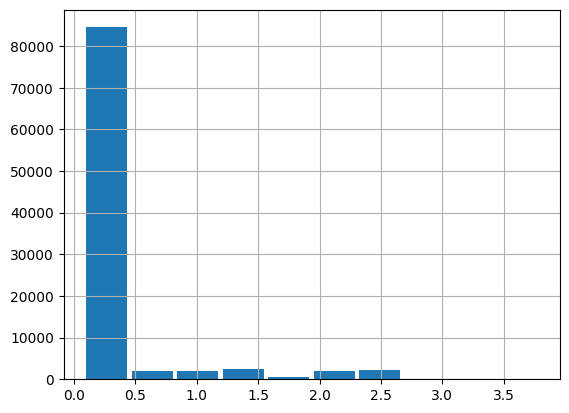

In [830]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

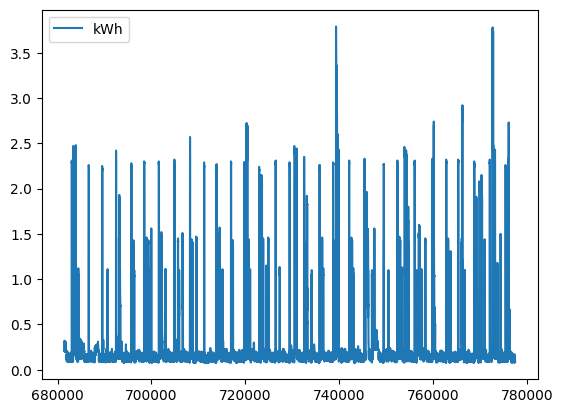

In [831]:
month.plot()

In [832]:
# index with max conso in this month
month.idxmax().kWh

np.int64(739299)

In [833]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       774542
hours     684983
months    681438
kWh       739299
dtype: int64

In [834]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [835]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
04/09/24 18     111     111    NaN   NaN
         19     163     274   52.0   NaN
         20     128     402  -35.0   NaN
         21     151     553   23.0   NaN
         22     149     702   -2.0   NaN
...             ...     ...    ...   ...
15/07/25 08     104    1070  -21.0   9.0
         09     111    1181    7.0  10.0
         10     111    1292    0.0  11.0
         11     684    1976  573.0  12.0
         12      50    2026 -634.0  13.0

[7531 rows x 4 columns]

In [836]:
month

,day,hours,months,kWh
681438,01,00,2025-04,0.21
681439,01,00,2025-04,0.21
681440,01,00,2025-04,0.21
681441,01,00,2025-04,0.21
681442,01,00,2025-04,0.21
...,...,...,...,...
777439,30,23,2025-04,0.09
777440,30,23,2025-04,0.09
777441,30,23,2025-04,0.09
777442,30,23,2025-04,0.09


In [837]:
month.idxmax()


day       774542
hours     684983
months    681438
kWh       739299
dtype: int64

In [838]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 739299, dtype: object

In [839]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       178
          01       175
          02       172
          03       118
          04       114
          05       111
          06       109
          07        99
          08       112
          09       110
          10       109
          11        98
          12       170
          13       144
          14       147
          15       134
          16       202
          17       142
          18       153
          19       196
          20       145
          21       148
          22       140
          23       176
Name: kWh, dtype: int64

In [840]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'16'

<Axes: xlabel='days,hours'>

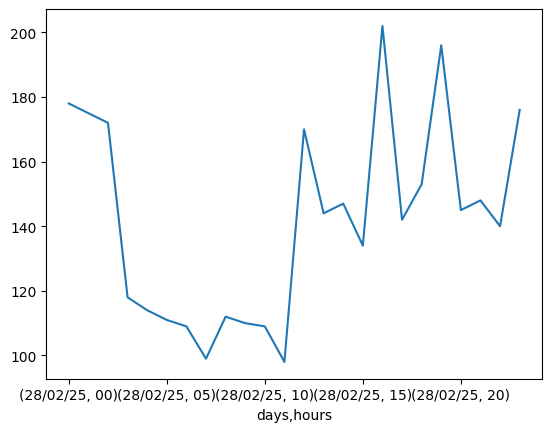

In [841]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [842]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [843]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [844]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [845]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB